<a href="https://colab.research.google.com/github/DLesmes/cvSrc/blob/main/modern_cv_gen_ai/train_object_detection_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# env

In [1]:
!pip install keras-cv==0.6.1 keras-core

In [2]:
!pip install -q tensorflow==2.15.1
!pip install -q tensorflow_hub==0.12.0
!pip install -q tensorflow_text==2.15.0
!pip install -q top2vec[sentence_transformers]

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.15.0 requires tensorflow-hub>=0.13.0, but you have tensorflow-hub 0.12.0 which is incompatible.


In [3]:
!pip freeze | grep keras

keras==2.15.0
keras-core==0.1.7
keras-cv==0.6.1
tf_keras==2.15.1


In [4]:
!pip freeze | grep tensorflow

tensorflow==2.15.1
tensorflow-datasets==4.9.6
tensorflow-estimator==2.15.0
tensorflow-hub==0.16.1
tensorflow-io-gcs-filesystem==0.37.1
tensorflow-metadata==1.16.1
tensorflow-probability==0.24.0
tensorflow-text==2.15.0


# Requirements

In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
#import tensorflow.keras as keras
from tensorflow.keras import optimizers
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
import resource
from keras_cv import visualization
import tqdm

Using TensorFlow backend


# Labels

In [6]:
# Get a dictionary pointing from int classes to class names
class_ids = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "Dining Table",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "Potted Plant",
    "Sheep",
    "Sofa",
    "Train",
    "Tvmonitor",
    "Total",
]

class_mapping = dict(zip(range(len(class_ids)), class_ids))
class_mapping

{0: 'Aeroplane',
 1: 'Bicycle',
 2: 'Bird',
 3: 'Boat',
 4: 'Bottle',
 5: 'Bus',
 6: 'Car',
 7: 'Cat',
 8: 'Chair',
 9: 'Cow',
 10: 'Dining Table',
 11: 'Dog',
 12: 'Horse',
 13: 'Motorbike',
 14: 'Person',
 15: 'Potted Plant',
 16: 'Sheep',
 17: 'Sofa',
 18: 'Train',
 19: 'Tvmonitor',
 20: 'Total'}

# Utils

## Visualize images amd bunding boxes

In [7]:
BATCH_SIZE = 4

def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
  """
  Visualizes a dataset of images and their corresponding bounding boxes in a grid format.

  Args:
      inputs (tf.data.Dataset or similar): A dataset or iterable containing batches of images and bounding boxes.
      value_range (tuple): The range of values for the images, typically in the form (min_value, max_value).
      rows (int): The number of rows in the grid visualization.
      cols (int): The number of columns in the grid visualization.
      bounding_box_format (str): The format of the bounding boxes (e.g., "xywh", "corners", etc.). This specifies how
          the bounding boxes are encoded.

  Returns:
      None: This function does not return anything. It displays a grid of images with bounding boxes overlaid.

  Example:
      >>> visualize_dataset(dataset, value_range=(0, 1), rows=2, cols=3, bounding_box_format='xywh')

  Notes:
      - This function assumes that `inputs` is a dataset with the structure `{"images": ..., "bounding_boxes": ...}`.
      - `class_mapping` should be defined globally or accessible in the scope where this function is called.
  """
  inputs = next(iter(inputs.take(1)))
  images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
  visualization.plot_bounding_box_gallery(
      images,
      value_range=value_range,
      rows=rows,
      cols=cols,
      y_true=bounding_boxes,
      scale=5,
      font_scale=0.7,
      bounding_box_format=bounding_box_format,
      class_mapping=class_mapping,
  )

## Bounding box formats mapping

To unpackage the tensorflow input we will use the [rel_xyxy](https://keras.io/api/keras_cv/bounding_box/formats/#rel_xyxy-class) format ✅

In [10]:
def unpackage_raw_tfds_inputs(inputs, bounding_box_format):
  """
    Unpacks and processes raw inputs from a TensorFlow Datasets (TFDS) dataset, converting bounding boxes to the desired format.

    Args:
        inputs (dict): A dictionary containing raw data from a TFDS dataset, with keys:
            - "image": The input image.
            - "objects": A dictionary containing bounding box information with keys:
                - "bboxes": The bounding boxes in the source format (e.g., "rel_xyxy").
                - "label": The labels or class ids for the objects.
        bounding_box_format (str): The target format for the bounding boxes (e.g., "xywh", "corners", etc.). This specifies how
            the bounding boxes should be encoded for further processing.

    Returns:
        dict: A dictionary with the following structure:
            - "images": The image tensor, cast to `tf.float32`.
            - "bounding_boxes": A dictionary containing:
                - "classes": The class labels, cast to `tf.float32`.
                - "boxes": The bounding boxes, cast to `tf.float32`, and converted to the specified target format.

    Example:
        >>> unpackage_raw_tfds_inputs(inputs, bounding_box_format="xywh")

    Notes:
        - The source format for the bounding boxes is assumed to be "rel_xyxy" (relative coordinates in the format [x_min, y_min, x_max, y_max]).
        - The `keras_cv.bounding_box.convert_format` utility is used to convert bounding boxes from the source to the target format.
  """
  image = inputs["image"]
  boxes = keras_cv.bounding_box.convert_format(
    inputs["objects"]["bbox"],
    images=image,
    source="rel_xyxy",
    target=bounding_box_format,
  )

  bounding_boxes = {
    "classes": tf.cast(inputs["objects"]["label"], dtype=tf.float32),
    "boxes": tf.cast(boxes, dtype=tf.float32),
  }

  return {
    "images": tf.cast(image, tf.float32),
    "bounding_boxes": bounding_boxes,
  }

In [11]:
def load_pascal_voc(split, dataset, bounding_box_format):
  """
    Loads and preprocesses the PASCAL VOC dataset using TensorFlow Datasets (TFDS).

    Args:
        split (str): The subset of the dataset to load (e.g., 'train', 'validation', or 'test').
        dataset (str): The name of the dataset to load (e.g., 'voc/2012').
        bounding_box_format (str): The format of the bounding boxes (e.g., 'xywh', 'corners').

    Returns:
        tf.data.Dataset: A TensorFlow dataset containing the preprocessed images and bounding boxes.
  """
  ds = tfds.load(
      dataset,
      split=split,
      with_info=False,
      shuffle_files=True
    )
  ds = ds.map(
      lambda x: unpackage_raw_tfds_inputs(
          x, bounding_box_format=bounding_box_format
      ),
      num_parallel_calls=tf.data.AUTOTUNE
  )
  return ds

# Data

Reading and formatting the data

In [12]:
%%time
train_ds = load_pascal_voc(
    split="train",
    dataset="voc/2007",
    bounding_box_format="xywh"
)

eval_ds = load_pascal_voc(
    split="test",
    dataset="voc/2007",
    bounding_box_format="xywh"
)

train_ds = train_ds.shuffle(BATCH_SIZE * 4)

CPU times: user 2.28 s, sys: 86.7 ms, total: 2.36 s
Wall time: 2.39 s


We use ragged batch since images can be of different sizes and each image can have variable number of objects

In [13]:
%%time
train_ds = train_ds.ragged_batch(
    BATCH_SIZE,
    drop_remainder=True
  )
eval_ds = eval_ds.ragged_batch(
    BATCH_SIZE,
    drop_remainder=True
  )

CPU times: user 230 ms, sys: 7.82 ms, total: 238 ms
Wall time: 230 ms


Visualize the dataset to ensure bounding boxes are in the right place
with correct labels. If done incorrectly, bounding boxes will not appear
or they will be in the wrong place.

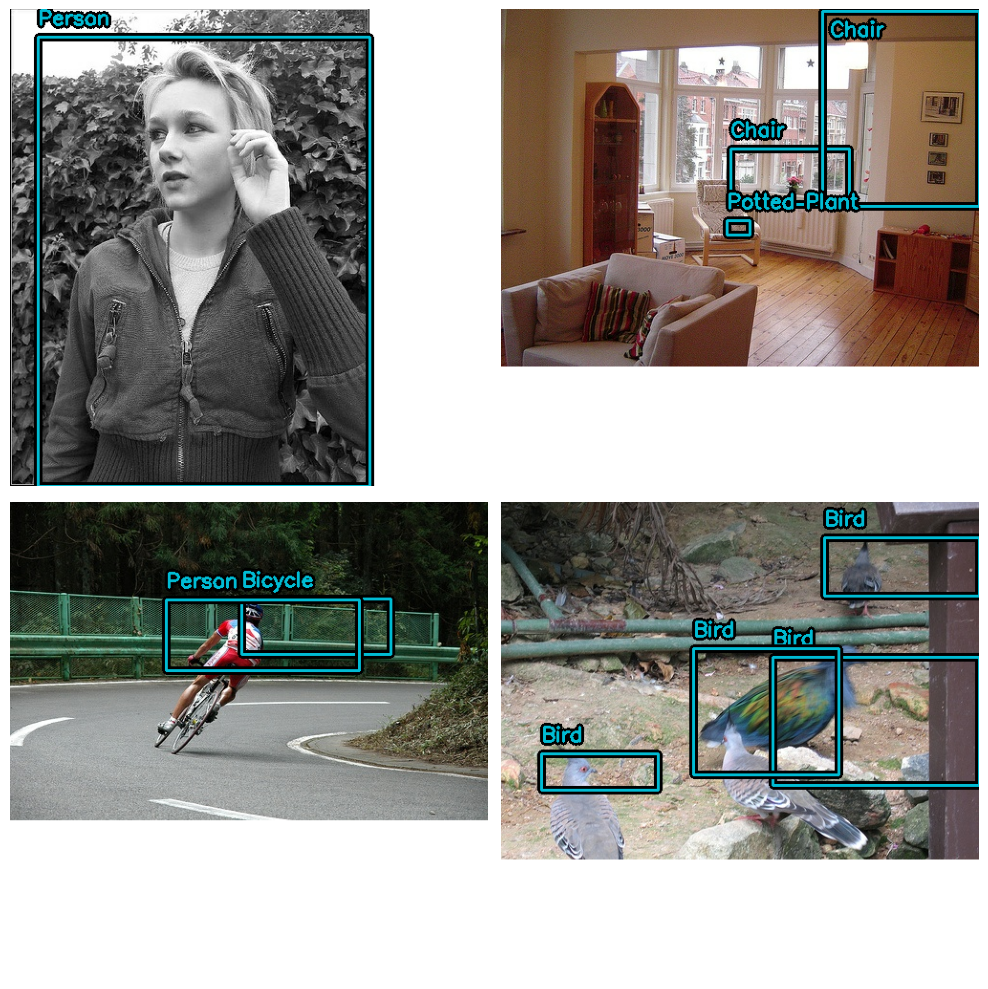

In [14]:
visualize_dataset(
    train_ds,
    bounding_box_format="xywh",
    value_range=(0, 255),
    rows=2,
    cols=2
)

Visualize validation set

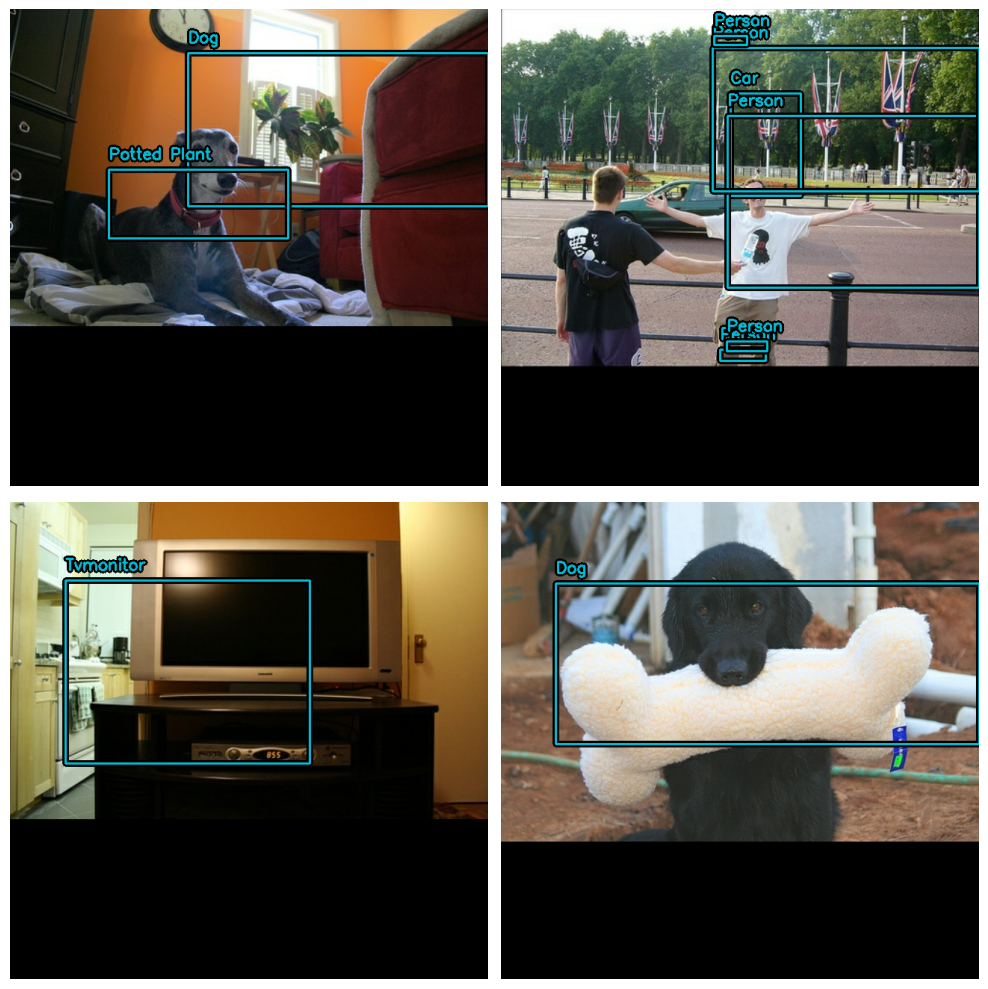

In [20]:
visualize_dataset(
    eval_ds,
    bounding_box_format="xywh",
    value_range=(0, 255),
    rows=2,
    cols=2,
)

## Data augmentation
Data augmentation is complex since after the image is modified, the bounding boxes must also be modified accordingly!

In [16]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(
            mode="horizontal",
            bounding_box_format="xywh",
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640),
            scale_factor=(0.75, 1.3),
            bounding_box_format="xywh",
        ),
    ]
)

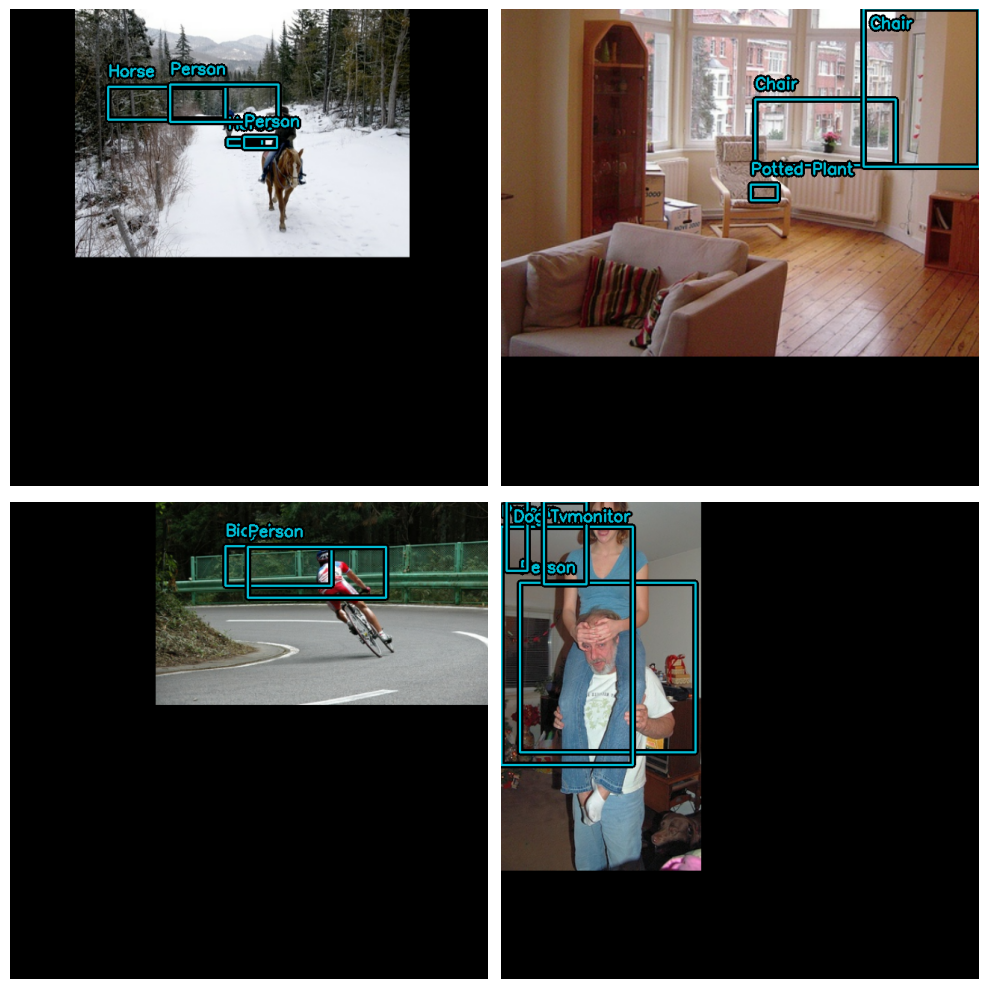

CPU times: user 4.52 s, sys: 818 ms, total: 5.34 s
Wall time: 4.5 s


In [21]:
%%time
train_ds = train_ds.map(
    augmenter,
    num_parallel_calls=tf.data.AUTOTUNE
    )

visualize_dataset(
    train_ds,
    bounding_box_format="xywh",
    value_range=(0, 255),
    rows=2,
    cols=2
)

Let's use deterministic resizing for the validation set

In [18]:
%%time
inference_resizing = keras_cv.layers.Resizing(
    640,
    640,
    bounding_box_format="xywh",
    pad_to_aspect_ratio=True
)

eval_ds = eval_ds.map(
    inference_resizing,
    num_parallel_calls=tf.data.AUTOTUNE
  )


CPU times: user 2.32 s, sys: 22 ms, total: 2.34 s
Wall time: 4.28 s


Let's make sure the resizing worked


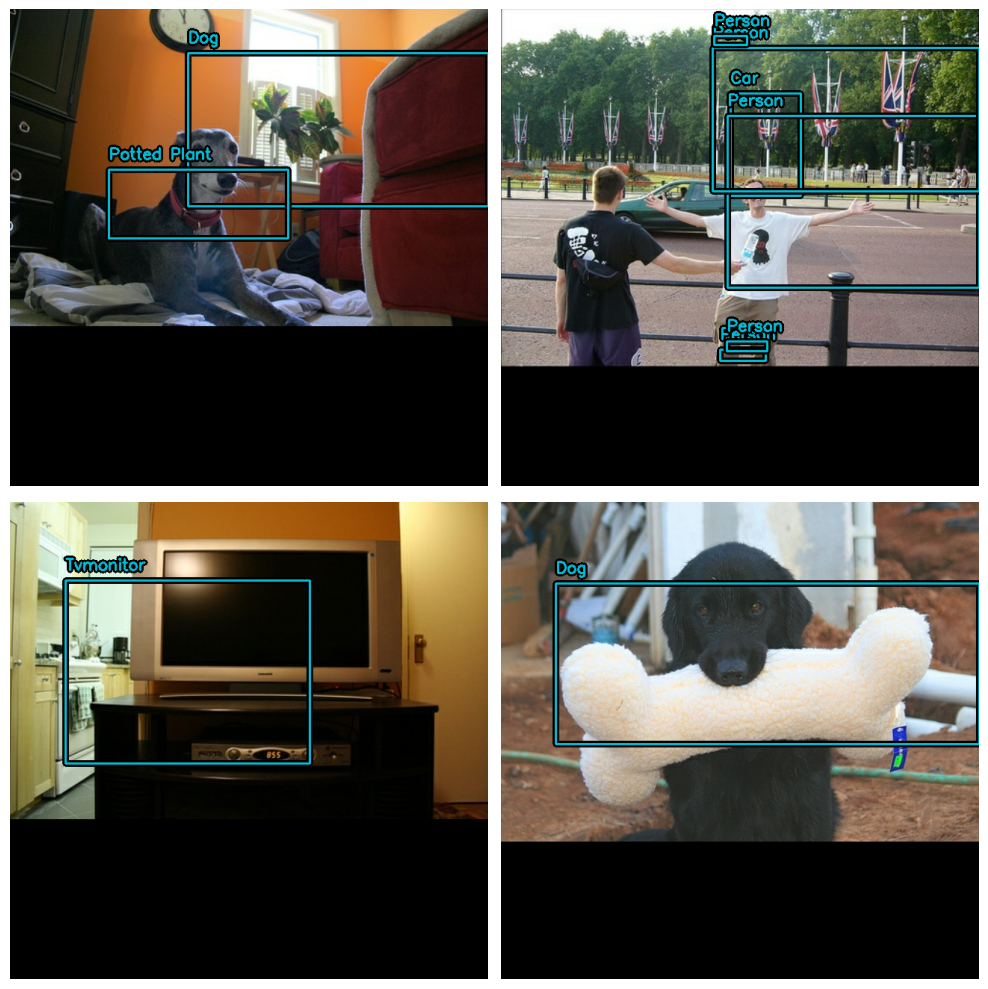

In [19]:
visualize_dataset(
    eval_ds,
    bounding_box_format="xywh",
    value_range=(0, 255),
    rows=2,
    cols=2
)

## Input format

This is the final form our model expects:
* tuple of (images, bounding_box_dictionary)
* to_dense() makes the batch compatible with TPU


In [22]:
def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"],
        max_boxes=32
    )

train_ds = train_ds.map(
    dict_to_tuple,
    num_parallel_calls=tf.data.AUTOTUNE
)
eval_ds = eval_ds.map(
    dict_to_tuple,
    num_parallel_calls=tf.data.AUTOTUNE
)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
eval_ds = eval_ds.prefetch(tf.data.AUTOTUNE)

# Hiperparameters

> Including a global_clipnorm is extremely important in object detection tasks




In [23]:
base_lr = 0.005

optimizer = tf.keras.optimizers.SGD(
    learning_rate=base_lr,
    momentum=0.9,
    global_clipnorm=10.0
)

# Model Architecture
Creates a "RetinaNet" from ResNet50 backbone

In [24]:
%%time
model = keras_cv.models.RetinaNet.from_preset(
    "resnet50_imagenet",
    num_classes=len(class_mapping),
    bounding_box_format="xywh",
)

model.compile(
    classification_loss="focal",
    box_loss="smoothl1",
    optimizer=optimizer,
)

94657128/94657128 [==============================] - 1s 0us/step
CPU times: user 4.72 s, sys: 675 ms, total: 5.4 s
Wall time: 5.79 s


# Training

> *Remove take(20) for full training (takes very long!)*



In [ ]:
%%time
model.fit(
    train_ds.take(20),
    validation_data=eval_ds.take(20),
    epochs=10
)

Epoch 1/10
 4/20 [=====>........................] - ETA: 10:30 - loss: 1.9006 - box_loss: 0.7233 - classification_loss: 1.1773 - percent_boxes_matched_with_anchor: 0.9258

Let's load a fully trained model to test predictions

In [ ]:
model = keras_cv.models.RetinaNet.from_preset(
    "retinanet_resnet50_pascalvoc",
    bounding_box_format="xywh"
)


construct a dataset with larger batches:

In [ ]:
%% time
visualization_ds = eval_ds.unbatch()
visualization_ds = visualization_ds.ragged_batch(16)
visualization_ds = visualization_ds.shuffle(8)

# Results

In [ ]:
def visualize_detections(model, dataset, bounding_box_format):
  """
    Visualizes object detection results by showing predicted bounding boxes
    alongside ground truth boxes for a batch of images.

    Args:
        model (tf.keras.Model): The trained object detection model used to make predictions.
        dataset (tf.data.Dataset): The dataset from which to sample a batch of images. It should
            yield images and their corresponding ground truth bounding boxes.
        bounding_box_format (str): The format of the bounding boxes (e.g., 'xywh', 'corners').
            This format must be consistent with both the ground truth boxes and the predicted boxes.

    Returns:
        None: The function creates a gallery of images with bounding boxes and displays it.

    Visualization Parameters:
        - The gallery will show both ground truth (y_true) and predicted (y_pred) bounding boxes.
        - The layout of the gallery is 2 rows and 4 columns, showing a total of 8 images.
        - Bounding boxes will be displayed with class labels, and the font size for annotations is adjustable.
  """
  images, y_true = next(iter(dataset.take(1)))
  y_pred = model.predict(images)
  y_pred = bounding_box.to_ragged(y_pred)
  visualization.plot_bounding_box_gallery(
      images,
      value_range=(0, 255),
      bounding_box_format=bounding_box_format,
      y_true=y_true,
      y_pred=y_pred,
      scale=4,
      rows=2,
      cols=4,
      show=True,
      font_scale=0.7,
      class_mapping=class_mapping,
  )

> ***To be clear, this model already has a prediction decoder! This is just showing you how to set parameters yourself.***

Set IoU and confidence threshold


In [ ]:
#
model.prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    iou_threshold=0.5,
    confidence_threshold=0.75,
)

visualize_detections(
  model,
  dataset=visualization_ds,
  bounding_box_format="xywh"
)